In [38]:
import casadi as ca
import matplotlib.pyplot as plt
%matplotlib inline

$m \ddot{x} + c \dot{x} + k x + sin(x) = u$

$\vec{x} = \begin{bmatrix}
x \\
\dot{x}
\end{bmatrix}$

$\vec{u} = \begin{bmatrix} u\end{bmatrix}$

$\vec{y} = \vec{g}(\vec{x}) = \begin{bmatrix} x\end{bmatrix}$

$\ddot{x} = (-c \dot{x} - kx + u)/m$

$\dot{\vec{x}} = \vec{f}(\vec{x}) = \begin{bmatrix}
\dot{x} \\
(-c \dot{x} - kx - sin(x) + u)/m
\end{bmatrix}$

$\dot{\vec{x}} = A \vec{x} + B \vec{u}$

$\vec{y} = C \vec{x} + D \vec{u}$

$A = \dfrac{\partial \vec{f}}{\partial \vec{x}}$

$B = \dfrac{\partial \vec{f}}{\partial \vec{u}}$

$C = \dfrac{\partial \vec{g}}{\partial \vec{x}}$

$D = \dfrac{\partial \vec{g}}{\partial \vec{u}}$

In [83]:
m = ca.SX.sym('m')
c = ca.SX.sym('c')
k = ca.SX.sym('k')
p = ca.vertcat(m, c, k)

u = ca.SX.sym('u')
xv = ca.SX.sym('x', 2)
x = xv[0]
xd = xv[1]

y = x

xv_dot = ca.vertcat(xd, (-c*xd - k*x - ca.sin(x) + u)/m)
xv_dot

SX([x_1, ((u-(((c*x_1)+(k*x_0))+sin(x_0)))/m)])

In [84]:
f_rhs = ca.Function('rhs', [xv, u, p], [xv_dot], ['x', 'u', 'p'], ['x_dot'], {'jit': True})
f_rhs

Function(rhs:(x[2],u,p[3])->(x_dot[2]) SXFunction)

In [85]:
f_rhs([1, 2], [0], [1, 2, 3])

DM([2, -7.84147])

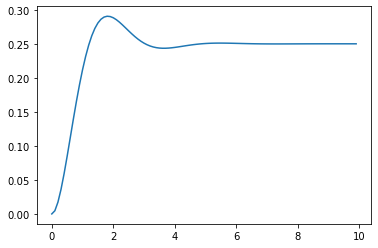

In [86]:
import scipy.integrate
import numpy as np
tf = 10
res = scipy.integrate.solve_ivp(
    fun=lambda t, x: np.array(f_rhs(x, 1.0, [1, 2, 3])).reshape(-1),
    t_span=[0, tf],
    y0=[0, 0], t_eval=np.arange(0, tf, 0.1))
plt.plot(res['t'], res['y'][0, :]);

In [87]:
A = ca.jacobian(xv_dot, xv)
A

SX(
[[00, 1], 
 [(-((k+cos(x_0))/m)), (-(c/m))]])

In [88]:
B = ca.jacobian(xv_dot, u)
B

SX([00, (1./m)])

In [89]:
C = ca.jacobian(y, xv)
C

SX([[1, 00]])

In [90]:
D = ca.jacobian(y, u)
D

SX(00)

In [94]:
f_ss = ca.Function('f_ss', [xv, p], [A, B, C, D], ['x', 'p'], ['A', 'B', 'C', 'D'])
f_ss

Function(f_ss:(x[2],p[3])->(A[2x2,3nz],B[2x1,1nz],C[1x2,1nz],D[1x1,0nz]) SXFunction)

In [95]:
import control
sys = control.ss(*f_ss([0, 0], [1, 2, 3]))
sys

A = [[ 0.  1.]
 [-4. -2.]]

B = [[0.]
 [1.]]

C = [[1. 0.]]

D = [[0.]]

In [98]:
f_rhs.generate('rhs.c')
!cat rhs.c

/* This file was automatically generated by CasADi.
   The CasADi copyright holders make no ownership claim of its contents. */
#ifdef __cplusplus
extern "C" {
#endif

/* How to prefix internal symbols */
#ifdef CODEGEN_PREFIX
  #define NAMESPACE_CONCAT(NS, ID) _NAMESPACE_CONCAT(NS, ID)
  #define _NAMESPACE_CONCAT(NS, ID) NS ## ID
  #define CASADI_PREFIX(ID) NAMESPACE_CONCAT(CODEGEN_PREFIX, ID)
#else
  #define CASADI_PREFIX(ID) rhs_ ## ID
#endif

#include <math.h>

#ifndef casadi_real
#define casadi_real double
#endif

#ifndef casadi_int
#define casadi_int long long int
#endif

/* Add prefix to internal symbols */
#define casadi_f0 CASADI_PREFIX(f0)
#define casadi_s0 CASADI_PREFIX(s0)
#define casadi_s1 CASADI_PREFIX(s1)
#define casadi_s2 CASADI_PREFIX(s2)

/* Symbol visibility in DLLs */
#ifndef CASADI_SYMBOL_EXPORT
  #if defined(_WIN32) || defined(__WIN32__) || defined(__CYGWIN__)
    #if defined(STATIC_LINKED)
      #define CASADI_SYMBOL_EXPORT
    #else
      #define CASADI_SYMBOL_E

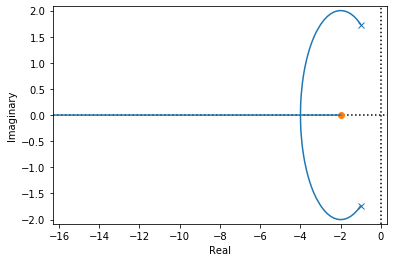

In [108]:
s = control.TransferFunction([1, 0], [0, 1])
H = (s + 2)
control.rlocus(H*sys);

In [107]:
H*sys


    s + 2
-------------
s^2 + 2 s + 4